# **Get data from Kaggle**

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fizarazvi10","key":"aadc4504649e37d6a08c1a82db2f3830"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download smaranjitghose/corn-or-maize-leaf-disease-dataset

 98% 157M/161M [00:05<00:00, 42.6MB/s]
100% 161M/161M [00:05<00:00, 31.5MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('corn-or-maize-leaf-disease-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# **Data Pre-processing**

In [6]:
# prompt: how to get the number images in  classes in the disease dataset, its like dataset/class/images type of structure

import os

# Get the path to the dataset directory
dataset_dir = "/content/data/"

# Get a list of all the classes
classes = os.listdir(dataset_dir)

# Create a dictionary to store the number of images in each class
class_counts = {}

# Loop through each class and count the number of images
for class_name in classes:
  class_dir = os.path.join(dataset_dir, class_name)
  images = os.listdir(class_dir)
  class_counts[class_name] = len(images)

# Print the number of images in each class
print(class_counts)


{'Healthy': 1162, 'Gray_Leaf_Spot': 574, 'Blight': 1146, 'Common_Rust': 1306}


Check images and their size

In [7]:
from PIL import Image
import os

# Define the path to your dataset directory
dataset_dir = "/content/data"

# Initialize a dictionary to store image sizes
image_sizes = {}

# Loop through each class directory in the dataset
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        # Loop through each image file in the class directory
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if os.path.isfile(file_path):
                # Open the image and get its size
                with Image.open(file_path) as img:
                    width, height = img.size
                    # Store the image size in the dictionary
                    if (width, height) not in image_sizes:
                        image_sizes[(width, height)] = 1
                    else:
                        image_sizes[(width, height)] += 1

# Print the image sizes and their frequencies
for size, count in image_sizes.items():
    print(f"Image size: {size}, Count: {count}")


Image size: (256, 256), Count: 3852
Image size: (432, 679), Count: 1
Image size: (527, 433), Count: 1
Image size: (400, 267), Count: 2
Image size: (432, 329), Count: 1
Image size: (300, 236), Count: 1
Image size: (349, 540), Count: 1
Image size: (852, 639), Count: 1
Image size: (267, 350), Count: 1
Image size: (690, 345), Count: 1
Image size: (508, 337), Count: 1
Image size: (651, 488), Count: 1
Image size: (5184, 3456), Count: 1
Image size: (299, 371), Count: 1
Image size: (482, 378), Count: 1
Image size: (400, 487), Count: 1
Image size: (360, 242), Count: 1
Image size: (1080, 614), Count: 1
Image size: (242, 195), Count: 1
Image size: (900, 675), Count: 2
Image size: (320, 228), Count: 1
Image size: (1200, 630), Count: 2
Image size: (743, 1591), Count: 1
Image size: (432, 273), Count: 1
Image size: (1500, 1048), Count: 1
Image size: (350, 230), Count: 1
Image size: (480, 320), Count: 4
Image size: (350, 299), Count: 1
Image size: (3264, 2448), Count: 7
Image size: (313, 213), Count: 

Rename files

In [8]:
import os

# Define the path to your dataset directory
dataset_dir = "/content/data"

# Loop through each class directory in the dataset
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        # Loop through each image file in the class directory
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if os.path.isfile(file_path):
                # Rename image file to be JPG
                new_file_path = os.path.join(class_dir, file_name.split('.')[0] + '.jpg')
                os.rename(file_path, new_file_path)


Remove images with brightness

In [9]:
import os
from PIL import Image

# Define the path to your dataset directory
dataset_dir = "/content/data"

# Define brightness threshold
brightness_threshold = 200

# Initialize a dictionary to store the count of removed images for each folder
removed_counts = {}

# Loop through each class directory in the dataset
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        removed_counts[class_name] = 0
        # Loop through each image file in the class directory
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if os.path.isfile(file_path):
                try:
                    # Open the image
                    with Image.open(file_path) as img:
                        # Calculate brightness
                        grayscale_img = img.convert("L")
                        brightness = sum(grayscale_img.getdata()) / (grayscale_img.size[0] * grayscale_img.size[1])
                        # Check brightness threshold
                        if brightness > brightness_threshold:
                            os.remove(file_path)
                            removed_counts[class_name] += 1
                except (UnidentifiedImageError, OSError):
                    print(f"Skipping {file_path} due to UnidentifiedImageError or OSError")
                    os.remove(file_path)

# Print the count of removed images for each folder
for class_name, count in removed_counts.items():
    print(f"Removed {count} bright images from folder {class_name}")


Removed 8 bright images from folder Healthy
Removed 0 bright images from folder Gray_Leaf_Spot
Removed 0 bright images from folder Blight
Removed 0 bright images from folder Common_Rust


Resize and transform image

In [10]:
import os
from PIL import Image
from PIL import UnidentifiedImageError  # Import UnidentifiedImageError
import torchvision.transforms as transforms

# Define the path to your dataset directory
dataset_dir = "/content/data"

# Define the transformations to be applied
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.Resize((224, 224)),  # Resize images to 256x256
])

# Loop through each class directory in the dataset
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        # Loop through each image file in the class directory
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if os.path.isfile(file_path):
                try:
                    # Open the image
                    with Image.open(file_path) as img:
                        # Apply transformations and save the image
                        transformed_img = transform(img)
                        transformed_img.save(file_path)
                except (UnidentifiedImageError, OSError):
                    print(f"Skipping {file_path} due to UnidentifiedImageError or OSError")
                    os.remove(file_path)


Skipping /content/data/Gray_Leaf_Spot/Corn_Gray_Spot (1).jpg due to UnidentifiedImageError or OSError
Skipping /content/data/Common_Rust/Corn_Common_Rust (1289).jpg due to UnidentifiedImageError or OSError
Skipping /content/data/Common_Rust/Corn_Common_Rust (1275).jpg due to UnidentifiedImageError or OSError
Skipping /content/data/Common_Rust/Corn_Common_Rust (1295).jpg due to UnidentifiedImageError or OSError


Check the size of images

In [11]:
from PIL import Image
import os

# Define the path to your dataset directory
dataset_dir = "/content/data"

# Initialize a dictionary to store image sizes
image_sizes = {}

# Loop through each class directory in the dataset
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        # Loop through each image file in the class directory
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if os.path.isfile(file_path):
                # Open the image and get its size
                with Image.open(file_path) as img:
                    width, height = img.size
                    # Store the image size in the dictionary
                    if (width, height) not in image_sizes:
                        image_sizes[(width, height)] = 1
                    else:
                        image_sizes[(width, height)] += 1

# Print the image sizes and their frequencies
for size, count in image_sizes.items():
    print(f"Image size: {size}, Count: {count}")

Image size: (224, 224), Count: 4175


Divide the dataset and normalize it

In [12]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

# Define dataset directory
data_dir = "/content/data"  # Update with your data directory

# Define transforms for preprocessing
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load dataset with transforms
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate split sizes
num_data = len(dataset)
num_train = int(train_ratio * num_data)
num_val = int(val_ratio * num_data)
num_test = num_data - num_train - num_val

# Split dataset indices
indices = list(range(num_data))
np.random.shuffle(indices)
train_indices = indices[:num_train]
val_indices = indices[num_train:num_train+num_val]
test_indices = indices[num_train+num_val:]

# # Split dataset into train and test
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [num_train, num_val, num_test])

# # Create data loaders for train and test sets
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Define data loaders for each set
train_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(val_indices))
test_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(test_indices))




# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# # Define dataset directory
# data_dir = "/content/data"  # Update with your data directory

# # Define transforms for preprocessing
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor()
# ])

# # Load dataset with transforms
# dataset = datasets.ImageFolder(data_dir, transform=transform)

# # Define the ratio for train-test split
# train_ratio = 0.8
# test_ratio = 0.2

# # Calculate split sizes
# num_data = len(dataset)
# num_train = int(train_ratio * num_data)
# num_test = num_data - num_train

# # Split dataset into train and test
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [num_train, num_test])

# # Create data loaders for train and test sets
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [14]:
print(num_train)
print(num_val)
print(num_test)

3340
417
418


# **ResNet18**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Training Loss: 0.8753, Training Accuracy: 67.37%
Validation Loss: 0.0914, Validation Accuracy: 75.78%
Epoch [2/10], Training Loss: 0.6095, Training Accuracy: 78.44%
Validation Loss: 0.0686, Validation Accuracy: 77.94%
Epoch [3/10], Training Loss: 0.4823, Training Accuracy: 79.52%
Validation Loss: 0.0587, Validation Accuracy: 77.70%
Epoch [4/10], Training Loss: 0.4236, Training Accuracy: 79.64%
Validation Loss: 0.0548, Validation Accuracy: 75.78%
Epoch [5/10], Training Loss: 0.3938, Training Accuracy: 80.60%
Validation Loss: 0.0506, Validation Accuracy: 77.46%
Epoch [6/10], Training Loss: 0.3607, Training Accuracy: 81.20%
Validation Loss: 0.0481, Validation Accuracy: 79.38%
Epoch [7/10], Training Loss: 0.3473, Training Accuracy: 81.89%
Validation Loss: 0.0463, Validation Accuracy: 79.14%
Epoch [8/10], Training Loss: 0.3349, Training Accuracy: 82.51%
Validation Loss: 0.0436, Validation Accuracy: 81.77%
Epoch [9/10], Training Loss: 0.3187, Training Accuracy: 83.50%
Validatio

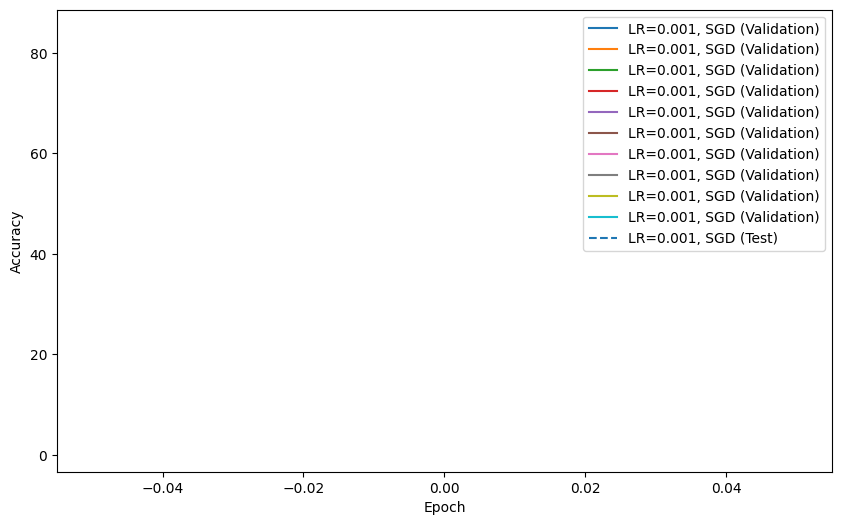

In [15]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define hyperparameters
learning_rates = [0.001]
num_epochs = 10
optimizers = [optim.SGD]

# Experiment with different hyperparameters
results = []

for lr in learning_rates:
    for optimizer_fn in optimizers:
        # Load ResNet18 model without pretrained weights
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, len(dataset.classes))  # Adjust output layer for classification

        # Define device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optimizer_fn(model.parameters(), lr=lr)

        # Lists to store training and validation metrics after each epoch
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = 100 * correct / total
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)

            print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%")

            # Evaluation on validation set after each epoch
            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            val_epoch_loss = val_running_loss / len(val_loader.dataset)
            val_epoch_accuracy = 100 * val_correct / val_total
            val_losses.append(val_epoch_loss)
            val_accuracies.append(val_epoch_accuracy)

            print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%")

        # Evaluation on test set
        model.eval()
        test_predictions = []
        test_labels = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                test_predictions.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        test_predictions = np.array(test_predictions)
        test_labels = np.array(test_labels)

        test_accuracy = accuracy_score(test_labels, test_predictions)
        test_precision = precision_score(test_labels, test_predictions, average='macro')
        test_recall = recall_score(test_labels, test_predictions, average='macro')
        test_f1 = f1_score(test_labels, test_predictions, average='macro')

        print(f"Test Accuracy: {test_accuracy:.2f}")
        print(f"Test Precision: {test_precision:.2f}")
        print(f"Test Recall: {test_recall:.2f}")
        print(f"Test F1 Score: {test_f1:.2f}")

        # Store results
        results.append({
            'learning_rate': lr,
            'optimizer': optimizer_fn.__name__,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'test_accuracy': test_accuracy,
        })

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
for lr in learning_rates:
    for optimizer_fn in optimizers:
        val_accs = [result['val_accuracies'] for result in results if result['learning_rate'] == lr and result['optimizer'] == optimizer_fn.__name__]
        ax.plot(val_accs, label=f"LR={lr}, {optimizer_fn.__name__} (Validation)")
        test_accs = [result['test_accuracy'] for result in results if result['learning_rate'] == lr and result['optimizer'] == optimizer_fn.__name__]
        ax.plot(test_accs, linestyle='--', label=f"LR={lr}, {optimizer_fn.__name__} (Test)")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()


In [16]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [17]:
model_path = '/content/drive/My Drive/resnet18_model_final.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

In [18]:
cornmaize_results = {}
cornmaize_results['ResNet18'] = {
    'learning_rate': lr,
    'optimizer': optimizer_fn.__name__,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'test_accuracy': test_accuracy,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1
}
cornmaize_results

{'ResNet18': {'learning_rate': 0.001,
  'optimizer': 'SGD',
  'train_losses': [0.8753088186458199,
   0.609522586925301,
   0.4823404152807361,
   0.42363822614361424,
   0.39380034603758485,
   0.36070818552713907,
   0.3472756396082347,
   0.3349441016648344,
   0.31867622149918606,
   0.3126259093513032],
  'train_accuracies': [67.36526946107784,
   78.44311377245509,
   79.52095808383234,
   79.64071856287426,
   80.59880239520957,
   81.19760479041916,
   81.88622754491018,
   82.51497005988024,
   83.50299401197604,
   83.8622754491018],
  'val_losses': [0.09135279853365379,
   0.06858393093069157,
   0.058700650180885175,
   0.054765103317931024,
   0.05061142955711502,
   0.048067893368041445,
   0.04625506800805737,
   0.04357016049459309,
   0.048208231383455015,
   0.041137204526248805],
  'val_accuracies': [75.77937649880096,
   77.93764988009592,
   77.6978417266187,
   75.77937649880096,
   77.45803357314149,
   79.37649880095923,
   79.13669064748201,
   81.7745803357314

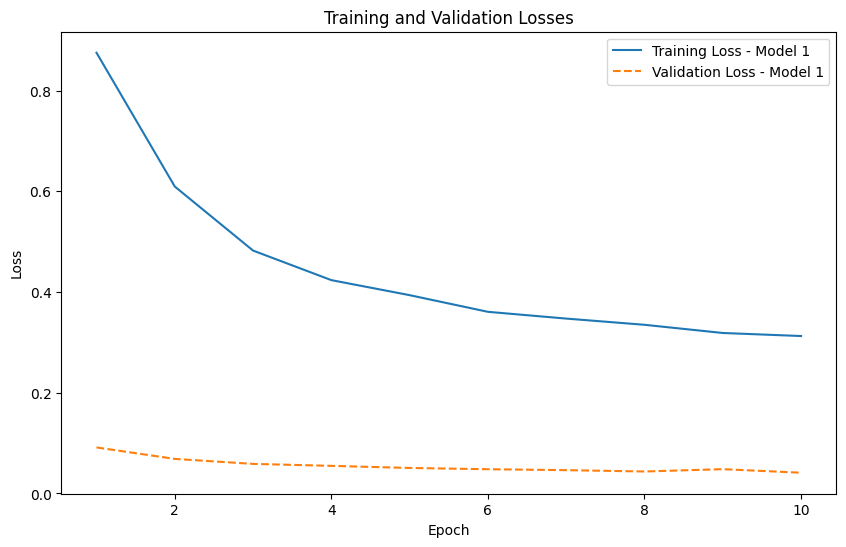

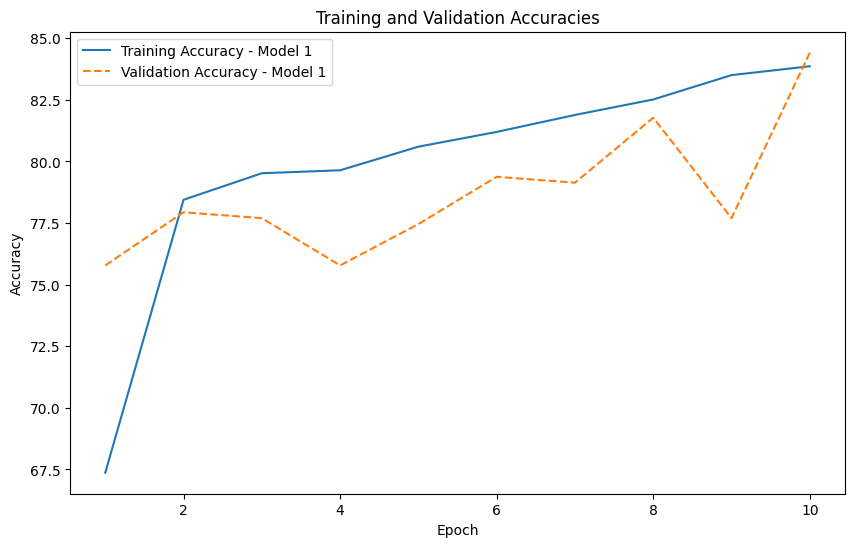

In [19]:
import matplotlib.pyplot as plt

# Extract data from results
train_losses = [result['train_losses'] for result in results]
train_accuracies = [result['train_accuracies'] for result in results]
val_losses = [result['val_losses'] for result in results]
val_accuracies = [result['val_accuracies'] for result in results]

# Plot training and validation losses
plt.figure(figsize=(10, 6))
for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
    plt.plot(range(1, len(train_loss) + 1), train_loss, label=f"Training Loss - Model {i+1}")
    plt.plot(range(1, len(val_loss) + 1), val_loss, linestyle='--', label=f"Validation Loss - Model {i+1}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
for i, (train_accuracy, val_accuracy) in enumerate(zip(train_accuracies, val_accuracies)):
    plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label=f"Training Accuracy - Model {i+1}")
    plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, linestyle='--', label=f"Validation Accuracy - Model {i+1}")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()


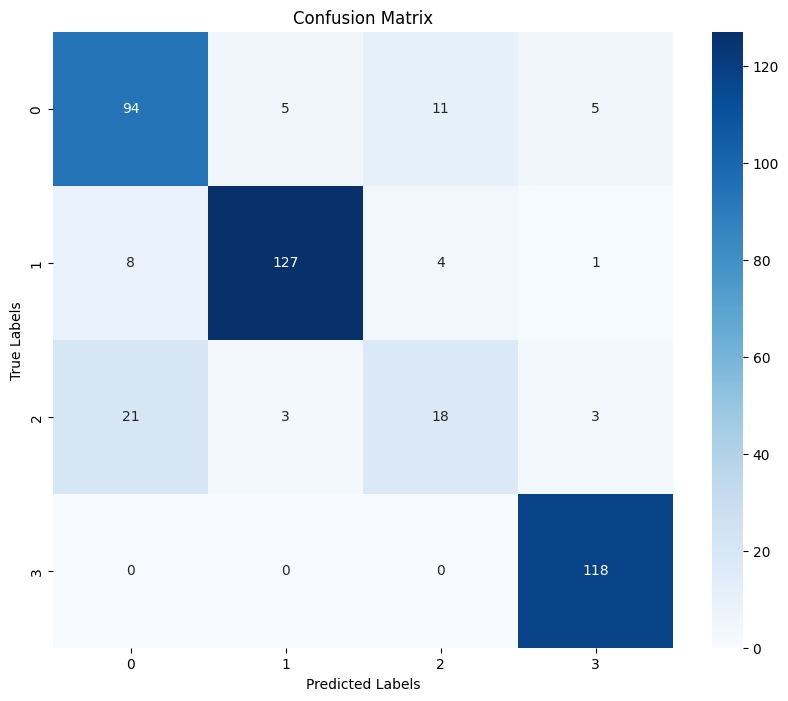

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# MobileNetV2

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision import models

# Define hyperparameters
learning_rates = [0.001]
num_epochs = 10
optimizers = [optim.SGD]

# Experiment with different hyperparameters
results = []

for lr in learning_rates:
    for optimizer_fn in optimizers:
        # Load MobileNetV2 model without pretrained weights
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(dataset.classes))  # Adjust output layer for classification

        # Define device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optimizer_fn(model.parameters(), lr=lr)

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            running_train_loss = 0.0
            correct_train = 0
            total_train = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            epoch_train_loss = running_train_loss / len(train_loader.dataset)
            train_losses.append(epoch_train_loss)
            train_accuracy = 100 * correct_train / total_train
            train_accuracies.append(train_accuracy)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

            # Validation
            model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            val_losses.append(epoch_val_loss)
            val_accuracy = 100 * correct_val / total_val
            val_accuracies.append(val_accuracy)
            print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Evaluation on test set
        model.eval()
        test_predictions = []
        test_labels = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                test_predictions.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        # Convert lists to numpy arrays
        test_predictions = np.array(test_predictions)
        test_labels = np.array(test_labels)

        # Compute evaluation metrics for test set
        test_accuracy = accuracy_score(test_labels, test_predictions)
        test_precision = precision_score(test_labels, test_predictions, average='macro')
        test_recall = recall_score(test_labels, test_predictions, average='macro')
        test_f1 = f1_score(test_labels, test_predictions, average='macro')

        print(f"Test Accuracy: {test_accuracy:.2f}")
        print(f"Test Precision: {test_precision:.2f}")
        print(f"Test Recall: {test_recall:.2f}")
        print(f"Test F1 Score: {test_f1:.2f}")

        # Store results
        results.append({
            'learning_rate': lr,
            'optimizer': optimizer_fn.__name__,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1
        })
        cornmaize_results['MobileNetV2'] = {
            'learning_rate': lr,
            'optimizer': optimizer_fn.__name__,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1
        }

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
for lr in learning_rates:
    for optimizer_fn in optimizers:
        val_accs = [result['val_accuracies'] for result in results if result['learning_rate'] == lr and result['optimizer'] == optimizer_fn.__name__]
        ax.plot(val_accs, label=f"LR={lr}, {optimizer_fn.__name__} (Validation)")
        test_accs = [result['test_accuracy'] for result in results if result['learning_rate'] == lr and result['optimizer'] == optimizer_fn.__name__]
        ax.plot(test_accs, linestyle='--', label=f"LR={lr}, {optimizer_fn.__name__} (Test)")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

# # Plot the results
# fig, ax = plt.subplots(figsize=(10, 6))
# for lr in learning_rates:
#     for optimizer_fn in optimizers:
#         val_accs = [result['val_accuracy'] for result in results if result['learning_rate'] == lr and result['optimizer'] == optimizer_fn.__name__]
#         ax.plot(val_accs, label=f"LR={lr}, {optimizer_fn.__name__} (Validation)")
#         test_accs = [result['test_accuracy'] for result in results if result['learning_rate'] == lr and result['optimizer'] == optimizer_fn.__name__]
#         ax.plot(test_accs, linestyle='--', label=f"LR={lr}, {optimizer_fn.__name__} (Test)")
# ax.set_xlabel('Epoch')
# ax.set_ylabel('Accuracy')
# ax.legend()
# plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


KeyboardInterrupt: 

In [ ]:
model_path = '/content/drive/My Drive/mobilenetv2_model_final.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

In [31]:
# cornmaise_results['MobileNetV2'] = {
#     'learning_rate': lr,
#     'optimizer': optimizer_fn.__name__,
#     'train_losses': train_losses,
#     'train_accuracies': train_accuracies,
#     'val_losses': val_losses,
#     'val_accuracies': val_accuracies,
#     'test_accuracy': test_accuracy,
#     'test_precision': test_precision,
#     'test_recall': test_recall,
#     'test_f1': test_f1
# }
cornmaize_results

{'ResNet18': {'learning_rate': 0.001,
  'optimizer': 'SGD',
  'train_losses': [0.8753088186458199,
   0.609522586925301,
   0.4823404152807361,
   0.42363822614361424,
   0.39380034603758485,
   0.36070818552713907,
   0.3472756396082347,
   0.3349441016648344,
   0.31867622149918606,
   0.3126259093513032],
  'train_accuracies': [67.36526946107784,
   78.44311377245509,
   79.52095808383234,
   79.64071856287426,
   80.59880239520957,
   81.19760479041916,
   81.88622754491018,
   82.51497005988024,
   83.50299401197604,
   83.8622754491018],
  'val_losses': [0.09135279853365379,
   0.06858393093069157,
   0.058700650180885175,
   0.054765103317931024,
   0.05061142955711502,
   0.048067893368041445,
   0.04625506800805737,
   0.04357016049459309,
   0.048208231383455015,
   0.041137204526248805],
  'val_accuracies': [75.77937649880096,
   77.93764988009592,
   77.6978417266187,
   75.77937649880096,
   77.45803357314149,
   79.37649880095923,
   79.13669064748201,
   81.7745803357314

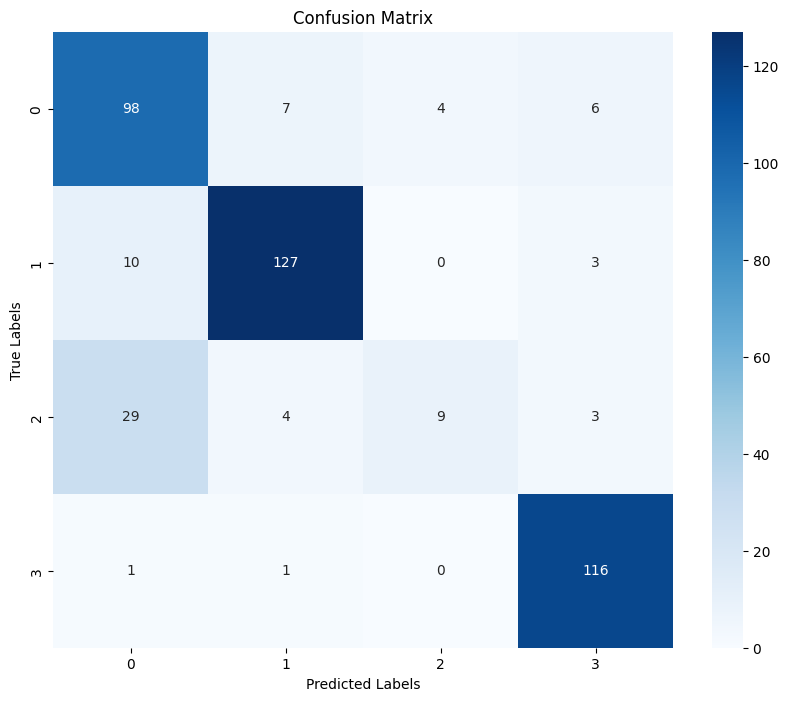

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


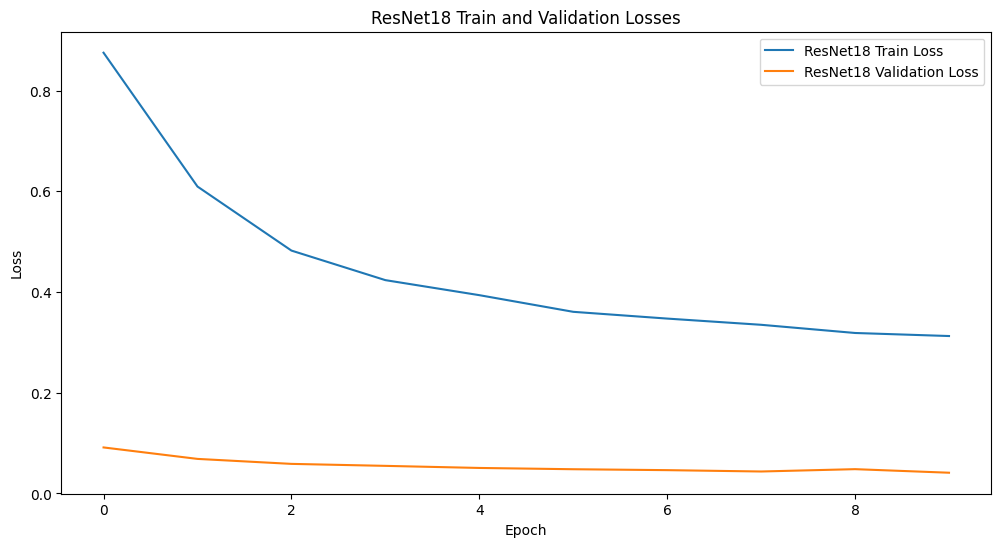

In [36]:
import matplotlib.pyplot as plt

# ResNet18 Losses
plt.figure(figsize=(12, 6))
plt.plot(cornmaize_results['ResNet18']['train_losses'], label='ResNet18 Train Loss')
plt.plot(cornmaize_results['ResNet18']['val_losses'], label='ResNet18 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet18 Train and Validation Losses')
plt.legend()
plt.show()



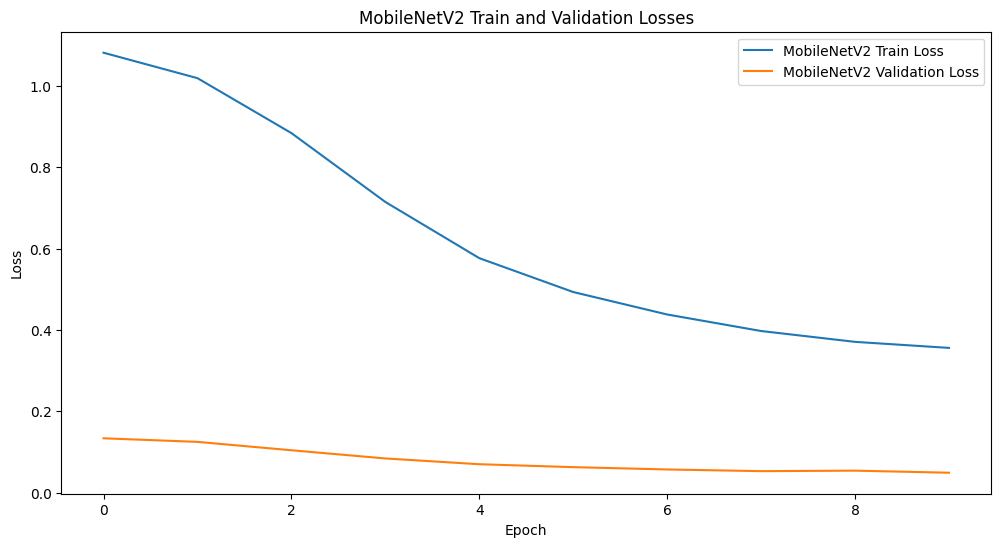

In [35]:
# MobileNetV2 Losses
plt.figure(figsize=(12, 6))
plt.plot(cornmaize_results['MobileNetV2']['train_losses'], label='MobileNetV2 Train Loss')
plt.plot(cornmaize_results['MobileNetV2']['val_losses'], label='MobileNetV2 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MobileNetV2 Train and Validation Losses')
plt.legend()
plt.show()

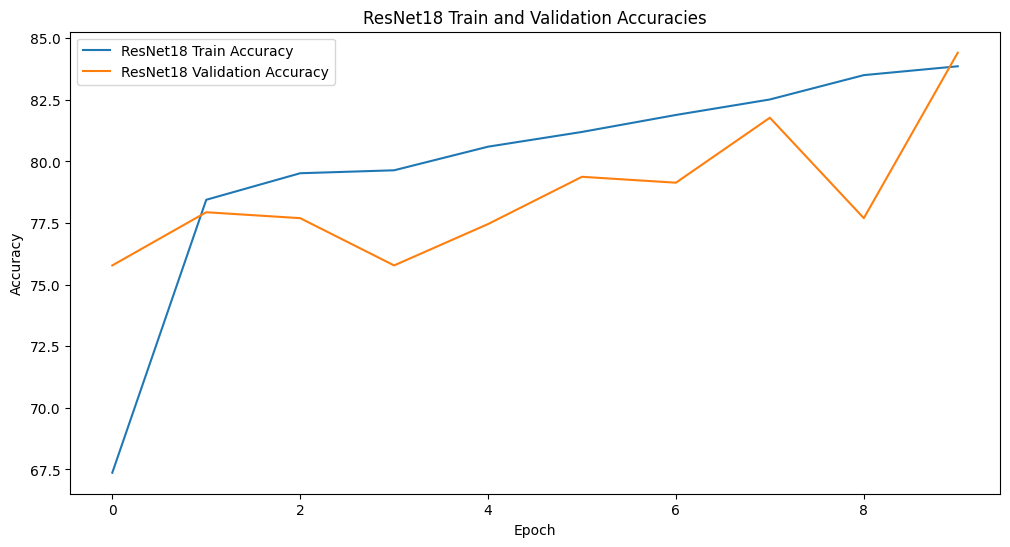

In [38]:
import matplotlib.pyplot as plt

# ResNet18 Accuracies
plt.figure(figsize=(12, 6))
plt.plot(cornmaize_results['ResNet18']['train_accuracies'], label='ResNet18 Train Accuracy')
plt.plot(cornmaize_results['ResNet18']['val_accuracies'], label='ResNet18 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet18 Train and Validation Accuracies')
plt.legend()
plt.show()




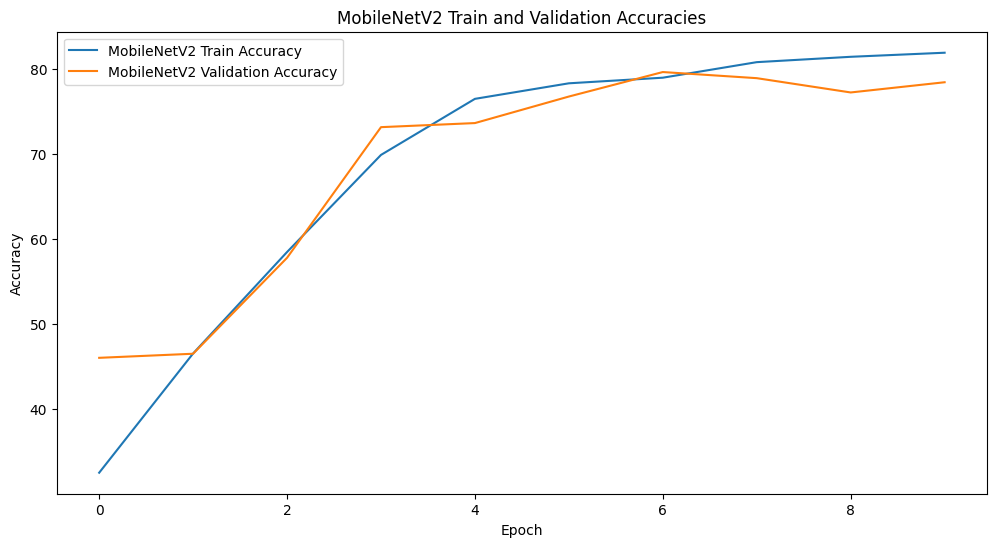

In [37]:
# MobileNetV2 Accuracies
plt.figure(figsize=(12, 6))
plt.plot(cornmaize_results['MobileNetV2']['train_accuracies'], label='MobileNetV2 Train Accuracy')
plt.plot(cornmaize_results['MobileNetV2']['val_accuracies'], label='MobileNetV2 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MobileNetV2 Train and Validation Accuracies')
plt.legend()
plt.show()

# Trying plots





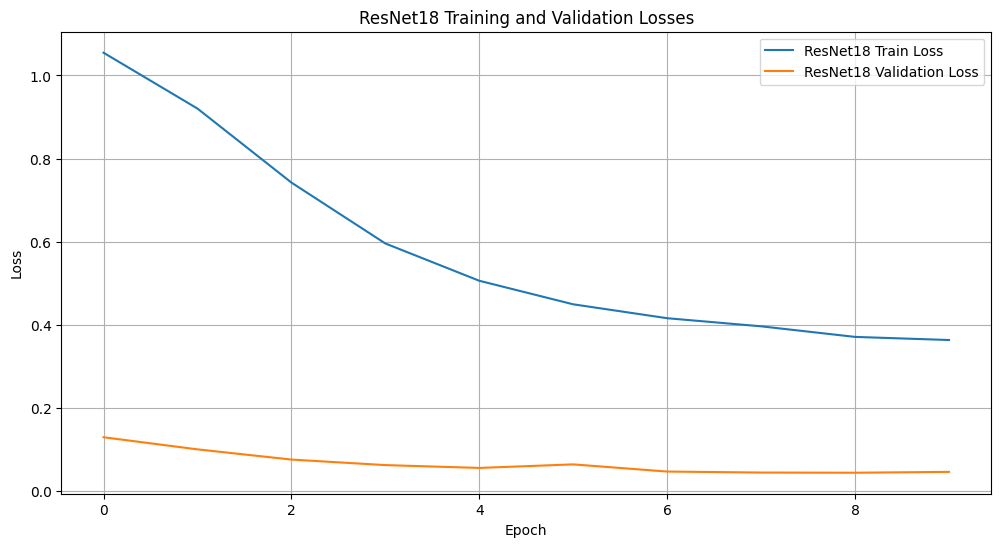

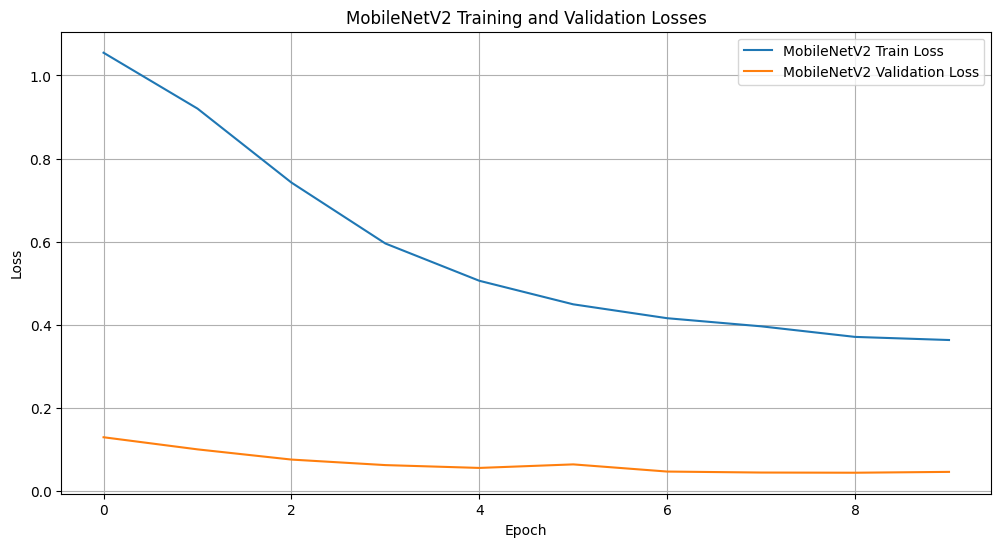

In [ ]:
# Plot training and validation losses
# Plot training and validation losses for ResNet18
plt.figure(figsize=(12, 6))
plt.plot(cornmaise_results['ResNet18']['train_losses'], label='ResNet18 Train Loss')
plt.plot(cornmaise_results['ResNet18']['val_losses'], label='ResNet18 Validation Loss')
plt.title('ResNet18 Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses for MobileNetV2
plt.figure(figsize=(12, 6))
plt.plot(cornmaise_results['MobileNetV2']['train_losses'], label='MobileNetV2 Train Loss')
plt.plot(cornmaise_results['MobileNetV2']['val_losses'], label='MobileNetV2 Validation Loss')
plt.title('MobileNetV2 Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

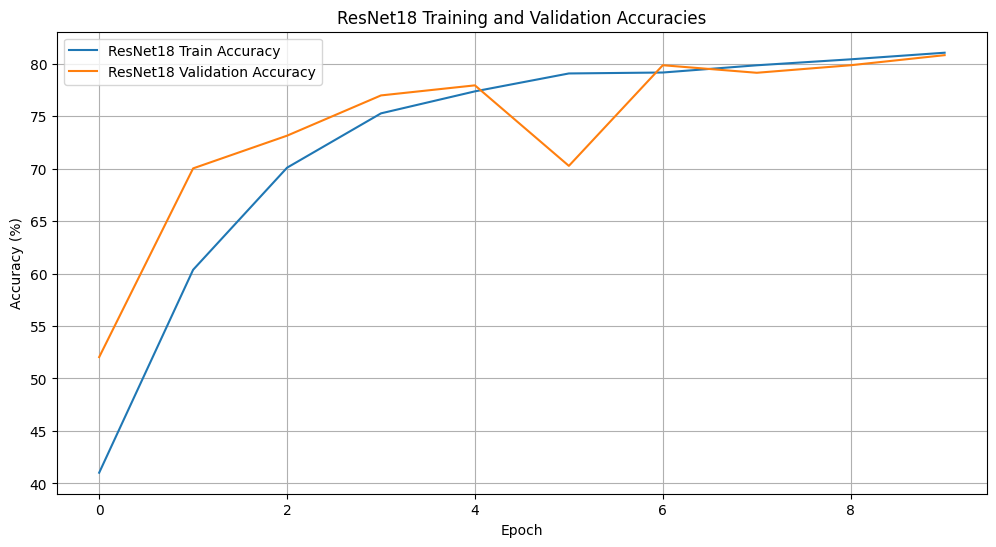

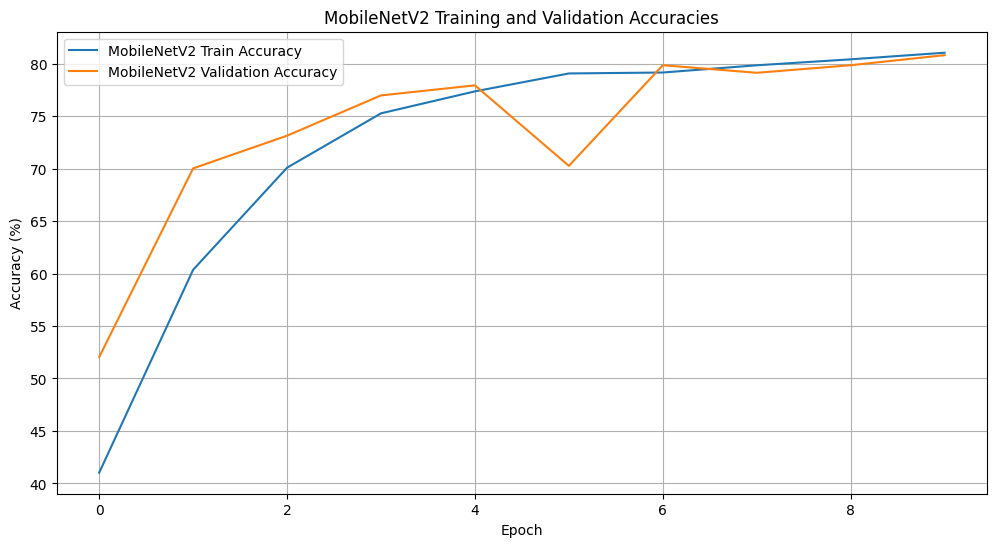

In [ ]:
# Plot training and validation accuracies for ResNet18
plt.figure(figsize=(12, 6))
plt.plot(cornmaise_results['ResNet18']['train_accuracies'], label='ResNet18 Train Accuracy')
plt.plot(cornmaise_results['ResNet18']['val_accuracies'], label='ResNet18 Validation Accuracy')
plt.title('ResNet18 Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracies for MobileNetV2
plt.figure(figsize=(12, 6))
plt.plot(cornmaise_results['MobileNetV2']['train_accuracies'], label='MobileNetV2 Train Accuracy')
plt.plot(cornmaise_results['MobileNetV2']['val_accuracies'], label='MobileNetV2 Validation Accuracy')
plt.title('MobileNetV2 Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
models = list(cornmaize_results.keys())

for model in models:
    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(cornmaize_results[model]['train_losses'], label='Train Loss')
    plt.plot(cornmaize_results[model]['val_losses'], label='Validation Loss')
    plt.title(f'{model} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(cornmaize_results[model]['train_accuracies'], label='Train Accuracy')
    plt.plot(cornmaize_results[model]['val_accuracies'], label='Validation Accuracy')
    plt.title(f'{model} Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

NameError: name 'cornmaize_results' is not defined

# Just Trying

In [ ]:
import matplotlib.pyplot as plt

# Results for each model
model_names = ['Resnet18', 'MobileNetV2']
test_accuracy = [[83.45, 83.93, 83.21, 84.41, 82.97, 84.89, 77.70, 86.57, 86.33, 85.37], [49.16, 58.75, 67.63, 70.74, 71.70,  77.94, 80.82, 81.77, 80.58, 82.25]]   # List of testing accuracy values for each model

# Plotting
plt.figure(figsize=(10, 6))
epochs = range(1, 11)

for i in range(len(model_names)):
    plt.plot(epochs, test_accuracy[i], label=f'{model_names[i]} (Test)', linestyle='--', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual data)
datasets = ['Corn & Maize', 'Corn & Maize', 'Corn & Maize']
models = ['ResNet18', 'MobileNetV2', 'Inception']
accuracies = np.array([[81, 87, 25], [81, 87, 25], [81, 87, 25]])  # Define accuracies as a 2D array with one row and two columns

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(datasets))

for i, model in enumerate(models):
    ax.bar(index + i * bar_width, accuracies[:, i], bar_width, label=model)

ax.set_xlabel('Dataset')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison of Different Models on Different Datasets')
ax.set_xticks(index + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels(datasets)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Training and validation accuracy over epochs
resnet_train_acc = [83.45, 83.93, 83.21, 84.41, 82.97, 84.89, 77.70, 86.57, 86.33, 85.37]
mobilenet_train_acc = [49.16, 58.75, 67.63, 70.74, 71.70, 77.94, 80.82, 81.77, 80.58, 82.25]

epochs = range(1, len(resnet_train_acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, resnet_train_acc, label='ResNet18', marker='o')
plt.plot(epochs, mobilenet_train_acc, label='MobileNetV2', marker='o')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Test set performance comparison
resnet_test_acc = 81
mobilenet_test_acc = 87

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
resnet_test_metrics = [81, 79, 73, 69]
mobilenet_test_metrics = [87, 82, 78, 78]

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(metrics))

plt.bar(index, resnet_test_metrics, bar_width, label='ResNet18', color='b', alpha=0.7)
plt.bar([i + bar_width for i in index], mobilenet_test_metrics, bar_width, label='MobileNetV2', color='r', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Test Set Performance Comparison')
plt.xticks([i + bar_width / 2 for i in index], metrics)
plt.legend()
plt.grid(True)
plt.show()
